#### This notebook fits a neural network over Headlines dataset for sarcasm detection!

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow import keras

tf.device = tf.device("gpu")

Load the dataset:

In [3]:
from normalizer import Normalizer
data = pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines = True)

Explore the data:

In [4]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


Check if the dataset is balanced?

In [6]:
len(data.loc[data["is_sarcastic"]==0])

14985

In [7]:
len(data.loc[data["is_sarcastic"]==1])

11724

There are 3000 sarcastic headlines more than non sarcastic headlines.

We don't need article link column we can drop it safely.

In [8]:
data = data.drop(columns=["article_link"])

Seperate the labels from the text.

In [9]:
X = data["headline"]
y = data["is_sarcastic"]

Now using the Normalization package that we created before, let's vectorize the text.

In [10]:
nm = Normalizer()
X_matrix = nm.vectorize(pd.DataFrame({"headline": X}))
X_matrix

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


<26709x25661 sparse matrix of type '<class 'numpy.float64'>'
	with 254896 stored elements in Compressed Sparse Row format>

Let's split the set into validation and train set:

In [11]:
X_train, X_Test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.33, random_state=42)

Now that we have the sparse matrix let's build a Multi Layer perceptron over this.

In [12]:
mlp = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

mlp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = mlp.fit(X_train.toarray(), y_train, epochs=10, batch_size=512, validation_data=(X_Test.toarray(), y_test))


Epoch 1/10
35/35 [==============================] - 3s 79ms/step - loss: 0.6802 - accuracy: 0.5588 - val_loss: 0.6609 - val_accuracy: 0.5591
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.6103 - accuracy: 0.6800 - val_loss: 0.5551 - val_accuracy: 0.8128
Epoch 3/10
35/35 [==============================] - 1s 39ms/step - loss: 0.4768 - accuracy: 0.8439 - val_loss: 0.4391 - val_accuracy: 0.8372
Epoch 4/10
35/35 [==============================] - 1s 39ms/step - loss: 0.3562 - accuracy: 0.8834 - val_loss: 0.3737 - val_accuracy: 0.8457
Epoch 5/10
35/35 [==============================] - 1s 41ms/step - loss: 0.2730 - accuracy: 0.9109 - val_loss: 0.3507 - val_accuracy: 0.8472
Epoch 6/10
35/35 [==============================] - 1s 38ms/step - loss: 0.2148 - accuracy: 0.9308 - val_loss: 0.3487 - val_accuracy: 0.8476
Epoch 7/10
35/35 [==============================] - 1s 36ms/step - loss: 0.1692 - accuracy: 0.9484 - val_loss: 0.3568 - val_accuracy: 0.8471
Epoch 8/10
35

Let's see the Training and Validation accuracy:

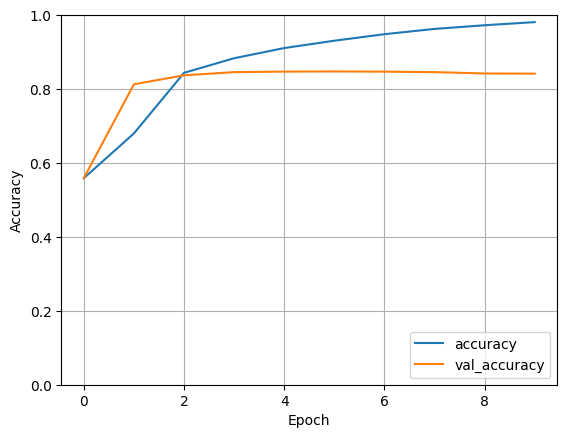

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

Let's see how the model does on loss:

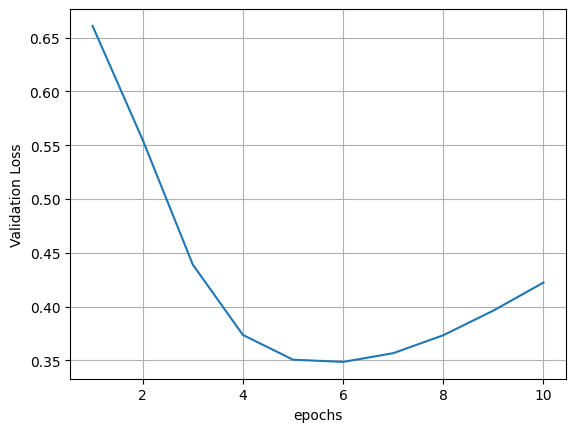

In [15]:
losses = history.history["val_loss"]
plt.plot(range(1,11), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

As we can see the validation loss increases after close to 5 epochs, it's better to early stop fitting, I guess the model is overfitting.

Let's refine the model:

In [16]:
mlp = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    
    keras.layers.Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
history = mlp.fit(X_train.toarray(), y_train, epochs=5, batch_size=512, validation_data=(X_Test.toarray(), y_test))


Epoch 1/5
35/35 [==============================] - 3s 72ms/step - loss: 0.6787 - accuracy: 0.5613 - val_loss: 0.6610 - val_accuracy: 0.5565
Epoch 2/5
35/35 [==============================] - 1s 38ms/step - loss: 0.6139 - accuracy: 0.6551 - val_loss: 0.5625 - val_accuracy: 0.7322
Epoch 3/5
35/35 [==============================] - 1s 35ms/step - loss: 0.4822 - accuracy: 0.8345 - val_loss: 0.4430 - val_accuracy: 0.8340
Epoch 4/5
35/35 [==============================] - 1s 36ms/step - loss: 0.3609 - accuracy: 0.8833 - val_loss: 0.3760 - val_accuracy: 0.8466
Epoch 5/5
35/35 [==============================] - 1s 35ms/step - loss: 0.2778 - accuracy: 0.9087 - val_loss: 0.3501 - val_accuracy: 0.8476


Let's see how the refined model performs:

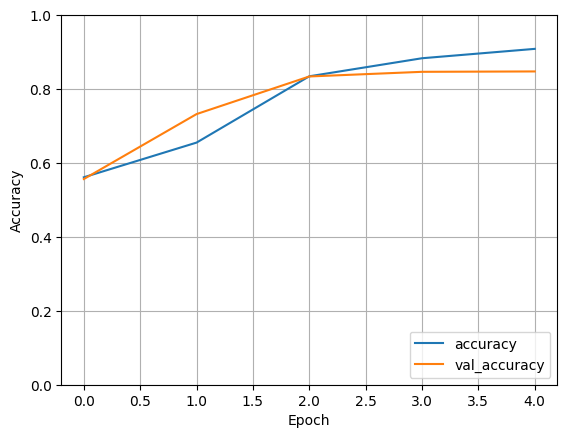

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

That's much better! Let's look at the validation loss:

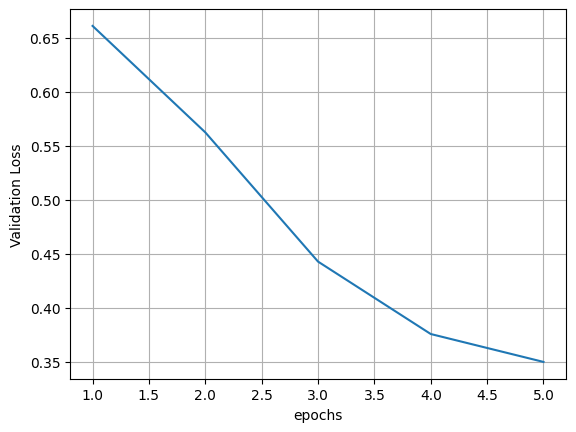

In [19]:
losses = history.history["val_loss"]
plt.plot(range(1,6), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

Great! the Loss decreases to the minimum of 0.35! that's wonderful.

In [20]:
X_Test

<8814x25661 sparse matrix of type '<class 'numpy.float64'>'
	with 84062 stored elements in Compressed Sparse Row format>

In [21]:
X_train

<17895x25661 sparse matrix of type '<class 'numpy.float64'>'
	with 170834 stored elements in Compressed Sparse Row format>

In [22]:
y_pred = mlp.predict(X_Test.toarray())

276/276 [==============================] - 1s 2ms/step


In [23]:
from sklearn.metrics import classification_report
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Step 3: Generate the classification report
report = classification_report(y_test, y_pred_binary)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4904
           1       0.83      0.82      0.83      3910

    accuracy                           0.85      8814
   macro avg       0.85      0.84      0.85      8814
weighted avg       0.85      0.85      0.85      8814



We are getting some decent scores using an Multilayer Perceptron.

Let's try and experiment with reddit data!

In [24]:
reddit_data = pd.read_csv("../dataset/reddit_human_validation_set_harsha.csv")

In [25]:
reddit_data.head(10)

,Unnamed: 0,text,label
0,0,Here's what happens when Obama gives up his Tw...,1
1,1,Monday night Drinking thread Brought to You by...,1
2,2,To make predators think they're poisonous? Exa...,1
3,3,"You are on the internet, you can watch everyth...",1
4,4,"Huma feigns ignorance, deflects blame to her W...",1
5,5,"I saw it described once that ""boys are for fun...",1
6,6,Protein shakes: easy and no chewing involved. ...,1
7,7,It amuses me the way you can armchair opinions...,1
8,8,Trump is an idiot and so is anyone who support...,1
9,9,why the fuck were you letting an 9 year old ha...,1


In [26]:
reddit_data = reddit_data.drop(columns=["Unnamed: 0"])

Let's get the representation for this dataset!

In [27]:
matrix = nm.get_matrix(reddit_data)

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


In [28]:
y_pred = mlp.predict(matrix.toarray())
from sklearn.metrics import classification_report
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)
report = classification_report(reddit_data["label"], y_pred_binary)
print(report)

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.81      0.60       250
           1       0.41      0.13      0.20       250

    accuracy                           0.47       500
   macro avg       0.44      0.47      0.40       500
weighted avg       0.44      0.47      0.40       500



### MLP using word embeddings: 

In [29]:
embeddings = Normalizer().get_embeddings(pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines=True))

[INFO] Trying to create word embeddings for this dataframe using Word2Vec model..
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Attempting further preprocessing using Tokenizer()
[INFO] Fitting a Word2Vec model for this text.
[INFO] Creating an embedding matrix!
[INFO] Word embeddings created! Successfully!


In [30]:
X_train, X_Test, y_train, y_test = train_test_split(embeddings, y, test_size=0.33, random_state=42)

In [43]:
mlp = keras.Sequential([
    keras.layers.Dense(128, activation='tanh', input_shape=(100, 100)),
    keras.layers.Dense(64, activation='tanh'),
    
    keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)  # Increased learning rate a bit
mlp.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

mlp.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100, 128)          12928     
                                                                 
 dense_19 (Dense)            (None, 100, 64)           8256      
                                                                 
 dense_20 (Dense)            (None, 100, 1)            65        
                                                                 
Total params: 21249 (83.00 KB)
Trainable params: 21249 (83.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = mlp.fit(X_train, y_train, epochs=13, batch_size=128, validation_data=(X_Test, y_test))


Epoch 1/13
140/140 [==============================] - 2s 13ms/step - loss: 0.6544 - accuracy: 0.5818 - val_loss: 0.6523 - val_accuracy: 0.5784
Epoch 2/13
140/140 [==============================] - 2s 11ms/step - loss: 0.6516 - accuracy: 0.5839 - val_loss: 0.6520 - val_accuracy: 0.5783
Epoch 3/13
140/140 [==============================] - 2s 11ms/step - loss: 0.6506 - accuracy: 0.5844 - val_loss: 0.6522 - val_accuracy: 0.5792
Epoch 4/13
140/140 [==============================] - 2s 12ms/step - loss: 0.6504 - accuracy: 0.5846 - val_loss: 0.6513 - val_accuracy: 0.5788
Epoch 5/13
140/140 [==============================] - 2s 12ms/step - loss: 0.6512 - accuracy: 0.5825 - val_loss: 0.6521 - val_accuracy: 0.5792
Epoch 6/13
140/140 [==============================] - 2s 13ms/step - loss: 0.6508 - accuracy: 0.5847 - val_loss: 0.6506 - val_accuracy: 0.5792
Epoch 7/13
140/140 [==============================] - 2s 13ms/step - loss: 0.6499 - accuracy: 0.5848 - val_loss: 0.6606 - val_accuracy: 0.5772

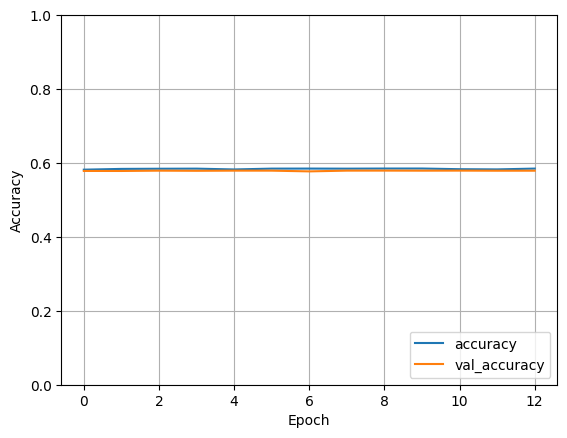

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

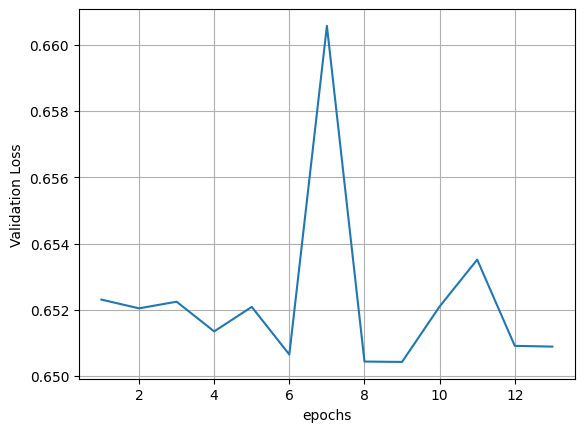

In [47]:
losses = history.history["val_loss"]
plt.plot(range(1,14), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [61]:
y_pred = mlp.predict(X_Test)


276/276 [==============================] - 1s 2ms/step
